In [11]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [12]:
# connecting to database
db = mysql.connector.connect(
    host = 'localhost',
    username = 'root',
    password = '1234',
    database = 'ecommerce'
)
cur = db.cursor()

### Questions

#### 1. List all unique cities where customers are located.

In [13]:
query = ''' select distinct(customer_city) from customers '''
cur.execute(query)
data = cur.fetchall()
df_U_S = pd.DataFrame(data, columns=['City'])
df_U_S.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#### 2. Count the number of orders placed in 2017.

In [14]:
query = ''' select count(order_id) from orders where 
year(order_purchase_timestamp) = 2017 '''
cur.execute(query)
data = cur.fetchall() # it returns a list of tuples
print(f'Total orders placed in 2017 are: {data[0][0]}')

Total orders placed in 2017 are: 45101


#### 3. Find the total sales per category.

In [15]:
query = ''' select upper(P.product_category), 
round(sum(O.price + O.freight_value), 2)
from order_items O join products P on O.product_id = P.product_id
group by P.product_category '''
cur.execute(query)
data = cur.fetchall()

In [16]:
# to create a data frame of catagory wise total sales
df_C_S = pd.DataFrame(data, columns = ['Category', 'Total_Sales'])
df_C_S.head()

,Category,Total_Sales
0,HEALTH BEAUTY,1441248.07
1,SPORT LEISURE,1156656.48
2,COOL STUFF,719329.95
3,COMPUTER ACCESSORIES,1059272.40
4,WATCHES PRESENT,1305541.61


#### 4. Calculate the percentage of orders that were paid in installments.

In [17]:
query = ''' select (sum(case when payment_installments >= 1 then 1
else 0 end)) / count(*) * 100 from payments'''
cur.execute(query)
data = cur.fetchall()
print(f'Percentage of products buy on installments: {data[0][0]}')

Percentage of products buy on installments: 99.9981


#### 5. Count the number of customers from each state.

In [18]:
query = ''' select customer_state, count(customer_id) 
from customers
group by customer_state'''
cur.execute(query)
data = cur.fetchall()
df_S_C = pd.DataFrame(data, columns=['State', 'Total_Customer'])
df_S_C.head()

,State,Total_Customer
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852


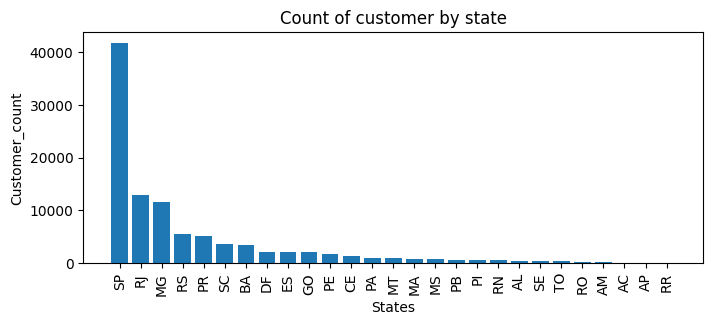

In [19]:
df_S_C = df_S_C.sort_values(by = 'Total_Customer', ascending=False) 
# to sort the chart in desc
plt.figure(figsize=(8,3))
plt.bar(df_S_C['State'], df_S_C['Total_Customer'])
plt.xticks(rotation = 90)
plt.xlabel('States')
plt.ylabel('Customer_count')
plt.title('Count of customer by state')
plt.show()

#### 6. Calculate the number of orders per month in 2018.

In [20]:
query = ''' select monthname(O.order_purchase_timestamp), 
count(O.order_id) from
(select order_id, order_purchase_timestamp 
from orders where year(order_purchase_timestamp) = 2018) O
group by monthname(O.order_purchase_timestamp)
'''
cur.execute(query)
data = cur.fetchall()
df_2018_M_S = pd.DataFrame(data, columns=['Month', 'Total Order'])
df_2018_M_S

,Month,Total Order
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


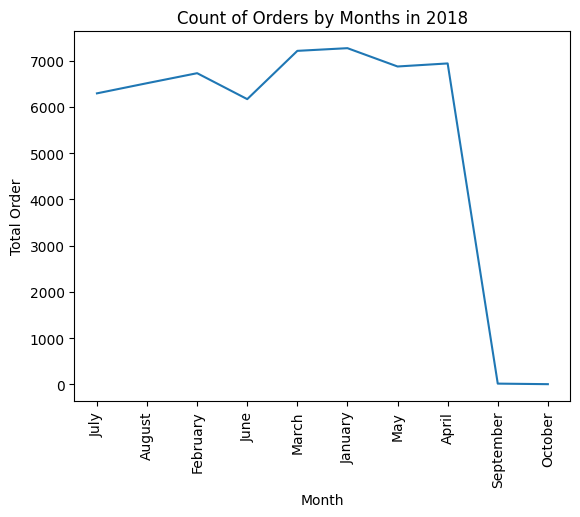

In [21]:
sns.lineplot(x = 'Month', y = 'Total Order', data = df_2018_M_S)
plt.xticks(rotation = 90)
plt.title('Count of Orders by Months in 2018')
plt.show()

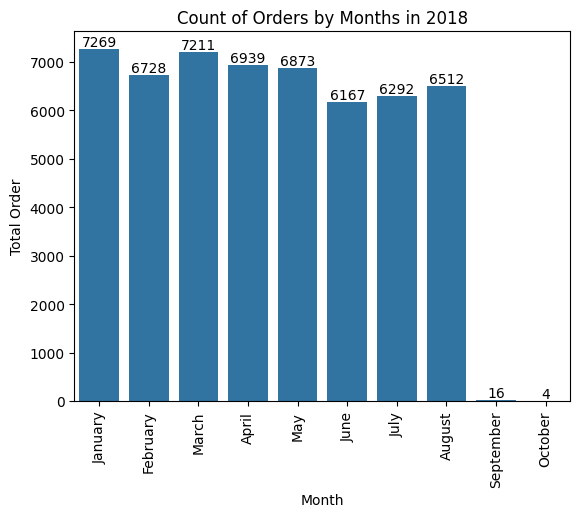

In [22]:
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
 'August', 'September', 'October']
ax = sns.barplot(x = 'Month', y = 'Total Order', data = df_2018_M_S,
 order=o)
plt.xticks(rotation = 90)
plt.bar_label(ax.containers[0])
plt.title('Count of Orders by Months in 2018')
plt.show()

#### 7. Find the average number of products per order, grouped by customer city.

In [23]:
query = ''' with count_per_order as 
(select orders.order_id, orders.customer_id, 
count(order_items.order_id) as OC
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)
select customers.customer_city, round(avg(count_per_order.OC), 2) 
avg_orders from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by avg_orders desc
'''
cur.execute(query)
data = cur.fetchall()
df_avg_P_O_C = pd.DataFrame(data, 
columns=['City', 'Avg_No_Product_Per_Order'])
df_avg_P_O_C.head()

,City,Avg_No_Product_Per_Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


#### 8. Calculate the percentage of total revenue contributed by each product category.

In [24]:
query = ''' select upper(P.product_category), 
round(sum(O.price + O.freight_value) * 100 / 
(select sum(price + freight_value) from order_items), 2) as 
revenuePerCatagory
from order_items O join products P on O.product_id = P.product_id
group by P.product_category
order by revenuePerCatagory desc;'''
cur.execute(query)
data = cur.fetchall()
df_revenue_per_catagory = pd.DataFrame(data, 
columns = ['Catagory','Revenue_Per_Catagory'])
df_revenue_per_catagory.head()

,Catagory,Revenue_Per_Catagory
0,HEALTH BEAUTY,9.10
1,WATCHES PRESENT,8.24
2,BED TABLE BATH,7.84
3,SPORT LEISURE,7.30
4,COMPUTER ACCESSORIES,6.69


#### 9. Identify the correlation between product price and the number of times a product has been purchased.


In [25]:
query = ''' select upper(p.product_category), 
count(o.product_id) as product_bought, round(avg(o.price), 2) as 
avg_price from products p join order_items o on p.product_id = o.product_id
group by p.product_category
order by product_bought desc'''
cur.execute(query)
data = cur.fetchall()
df_buying_details_per_catagory = pd.DataFrame(data, 
columns = ['Catagory','Order_Count', 'Avg_Price'])
df_buying_details_per_catagory.head()

# to get corelation
arr1 = df_buying_details_per_catagory['Order_Count']
arr2 = df_buying_details_per_catagory['Avg_Price']
print(f'Correlation Between product price and the number of times a product has been purchased is: {round(np.corrcoef([arr1, arr2])[0][1], 2)}')

Correlation Between product price and the number of times a product has been purchased is: -0.11


#### 10. Calculate the total revenue generated by each seller, and rank them by revenue.


In [26]:
query = ''' select *, dense_rank() over(order by revenue desc) from
(select s.seller_id, round(sum(p.payment_value), 2) as revenue 
from sales s join order_items o on s.seller_id = o.seller_id 
join payments p on p.order_id = o.order_id
group by s.seller_id) as a
'''
cur.execute(query)
data = cur.fetchall()
df_rank_of_seller = pd.DataFrame(data, 
columns = ['Seller_ID','Revenue', 'Rank'])
df_rank_of_seller.head()

,Seller_ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


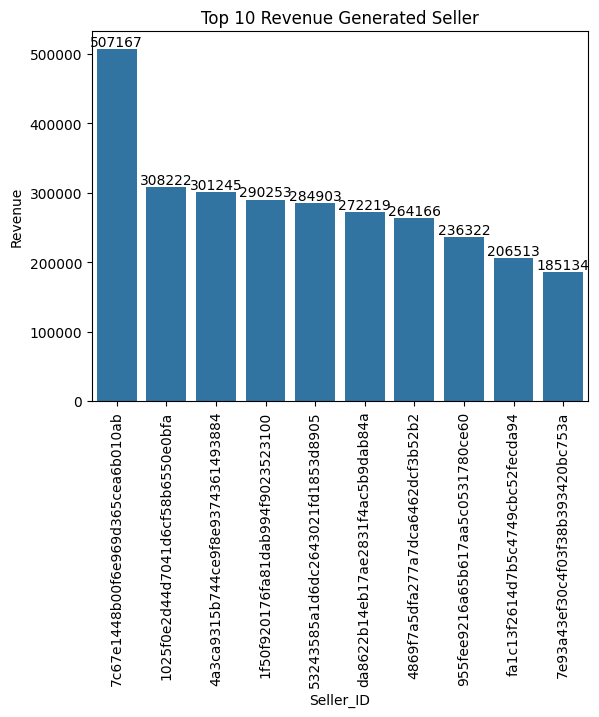

In [27]:
ax = sns.barplot(x = 'Seller_ID', y = 'Revenue', 
data = df_rank_of_seller.head(10))
plt.xticks(rotation = 90)
plt.bar_label(ax.containers[0])
plt.title('Top 10 Revenue Generated Seller')
plt.show()

#### 11. Calculate the moving average of order values for each customer over their order history.

In [28]:
query = ''' select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by 
order_purchase_timestamp rows between 2 preceding and current row) as 
mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment from payments join orders
on payments.order_id = orders.order_id) as a
'''
cur.execute(query)
data = cur.fetchall()
df_mov_avg= pd.DataFrame(data, 
columns = ['Customer_ID','Timestamp', 'Payment', 'Moving_Avg'])
df_mov_avg.head(5)

,Customer_ID,Timestamp,Payment,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


#### 12. Calculate the cumulative sales per month for each year.


In [29]:
query = ''' select year, month, round(sum(revenue) 
over(order by year, month), 2) as Cumulative_Sum from
(select year(o.order_purchase_timestamp) year, 
month(o.order_purchase_timestamp) month, round(sum(p.payment_value), 2)
revenue from orders o join payments p on o.order_id = p.order_id
group by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp)
order by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp))
 as a
'''
cur.execute(query)
data = cur.fetchall()
df_cum_sales1 = pd.DataFrame(data, 
columns = ['Year','Month', 'Cumulative_Sales'])
df_cum_sales1

,Year,Month,Cumulative_Sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


In [30]:
query = ''' select year, month, round(sum(revenue) 
over(partition by year order by month), 2) as Cumulative_Sum from
(select year(o.order_purchase_timestamp) year, 
month(o.order_purchase_timestamp) month, round(sum(p.payment_value), 2) 
revenue from orders o join payments p on o.order_id = p.order_id
group by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp)
order by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp))
 as a
'''
cur.execute(query)
data = cur.fetchall()
df_cum_sales2 = pd.DataFrame(data, columns = ['Year','Month', 'Cumulative_Sales'])
df_cum_sales2

,Year,Month,Cumulative_Sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,138488.04
4,2017,2,430396.05
5,2017,3,880259.65
6,2017,4,1298047.68
7,2017,5,1890966.50
8,2017,6,2402242.88
9,2017,7,2994625.80


#### 13. Calculate the year-over-year growth rate of total sales.


In [32]:
# year-over-year percentage growth formula ((current - last) / last) * 100
query = ''' with a as (select year(o.order_purchase_timestamp) year, 
round(sum(p.payment_value), 2) revenue
from orders o join payments p on o.order_id = p.order_id
group by year(o.order_purchase_timestamp)
order by year)
select year, round(((revenue - lag(revenue, 1) 
over(order by year)) / lag(revenue, 1) over(order by year)) * 100,2)
 from a
'''
cur.execute(query)
data = cur.fetchall()
df_yoy_P_G = pd.DataFrame(data, columns = ['Year','yoy%Growth'])
df_yoy_P_G

,Year,yoy%Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


#### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [33]:
query = ''' with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp)
 next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;
'''
cur.execute(query)
data = cur.fetchall()
print(f'The retention rate of customers: {data[0][0]}')

The retention rate of customers: None


#### 15. Identify the top 3 customers who spent the most money in each year.


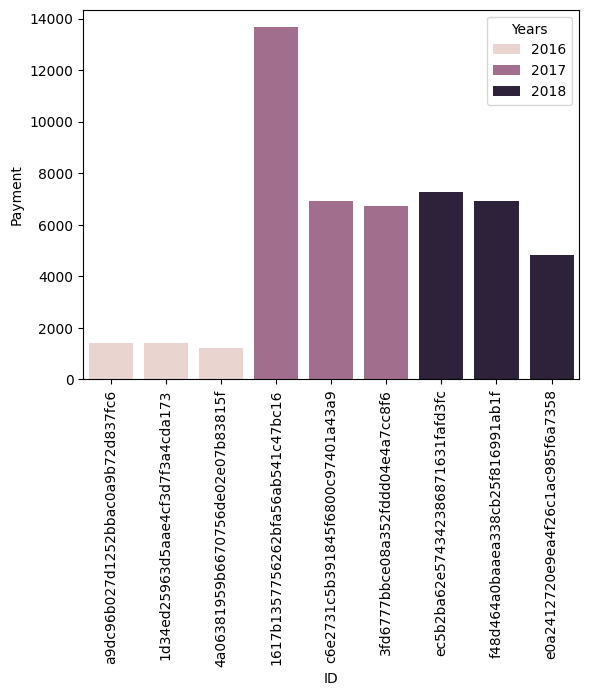

In [34]:
query = """select years, customer_id, payment, d_rank from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3"""
cur.execute(query)
data = cur.fetchall()
df_top_customer = pd.DataFrame(data, columns = ["Years","ID","Payment","Rank"])
sns.barplot(x = "ID", y = "Payment", data = df_top_customer, hue = "Years")
plt.xticks(rotation = 90)
plt.show()